In [2]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

In [3]:
from scipy import stats
import scikit_posthocs as sp

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("settles.acl16.learning_traces.13m.csv")
print(len(df))
df.head()

12854226


,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2
1,0.5,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1
2,1.0,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1
3,0.5,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1
4,1.0,1362076081,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,4,4,1,1


In [6]:
df.groupby("learning_language").size()

learning_language
de    1452597
en    5014791
es    3407689
fr    1873734
it     793935
pt     311480
dtype: int64

In [7]:
df.groupby(["ui_language", "learning_language"]).size()

ui_language  learning_language
en           de                   1452597
             es                   3407689
             fr                   1873734
             it                    793935
             pt                    311480
es           en                   3641179
it           en                    424152
pt           en                    949460
dtype: int64

# Q1: Difference between pairs of ui_language and learning_language 

In [8]:
pair_grouped = list(df.groupby(["ui_language", "learning_language"]))

In [9]:
data = {}

for pair in tqdm(pair_grouped):
    pair_data = []
    relevant_rows = df[(df.ui_language == pair[0][0]) &( df.learning_language == pair[0][1])]
    user_grouped = list(relevant_rows.groupby("user_id"))
    for user in tqdm(user_grouped, leave=True):
        lexeme_grouped = user[1].groupby("lexeme_id")
        
        user_performance = []
        for lexeme in lexeme_grouped:
            last_entry = lexeme[1].iloc[-1]
            user_performance.append(last_entry.history_correct/last_entry.history_seen)
        user_performance_aggregate = np.mean(user_performance) # Replace with mean?
        pair_data.append(user_performance_aggregate)
    
    data[pair[0]] = pair_data

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/14383 [00:00<?, ?it/s]

  0%|          | 0/31155 [00:00<?, ?it/s]

  0%|          | 0/19947 [00:00<?, ?it/s]

  0%|          | 0/6498 [00:00<?, ?it/s]

  0%|          | 0/2709 [00:00<?, ?it/s]

  0%|          | 0/31735 [00:00<?, ?it/s]

  0%|          | 0/3436 [00:00<?, ?it/s]

  0%|          | 0/8637 [00:00<?, ?it/s]

In [10]:
[x for x in data]

[('en', 'de'),
 ('en', 'es'),
 ('en', 'fr'),
 ('en', 'it'),
 ('en', 'pt'),
 ('es', 'en'),
 ('it', 'en'),
 ('pt', 'en')]

In [11]:
[len(data[x]) for x in data]

[14383, 31155, 19947, 6498, 2709, 31735, 3436, 8637]

In [12]:
pairs = sorted(data.keys(), key=lambda x: len(data[x]))

Text(0, 0.5, '(UI-Language, Learning-Language)')

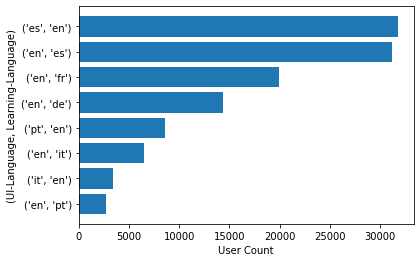

In [13]:
fig, ax = plt.subplots(1, 1)
ax.barh([str(x) for x in pairs], [len(data[x]) for x in pairs])

ax.set_xlabel("User Count")
ax.set_ylabel("(UI-Language, Learning-Language)")

In [14]:
stats.levene(*[data[x] for x in data])

LeveneResult(statistic=99.55262401523076, pvalue=8.926990488194741e-146)

In [15]:
stats.kruskal(*[data[x] for x in data])

KruskalResult(statistic=978.81909269643, pvalue=4.538988672550323e-207)

In [16]:
sp.posthoc_mannwhitney([data[x] for x in data], p_adjust = 'bonferroni')

,1,2,3,4,5,6,7,8
1,1.000000e+00,1.213954e-10,2.306207e-95,6.497860e-46,1.000000e+00,9.593619e-05,5.454411e-19,1.000000e+00
2,1.213954e-10,1.000000e+00,1.497488e-68,1.651503e-25,4.083483e-02,6.375086e-02,5.629129e-41,3.290010e-04
3,2.306207e-95,1.497488e-68,1.000000e+00,1.000000e+00,9.646612e-25,3.389798e-95,1.029523e-99,8.431562e-61
4,6.497860e-46,1.651503e-25,1.000000e+00,1.000000e+00,3.940654e-18,2.360877e-35,3.788536e-74,6.466340e-33
5,1.000000e+00,4.083483e-02,9.646612e-25,3.940654e-18,1.000000e+00,1.000000e+00,1.009979e-10,1.000000e+00
6,9.593619e-05,6.375086e-02,3.389798e-95,2.360877e-35,1.000000e+00,1.000000e+00,2.397575e-34,3.918676e-01
7,5.454411e-19,5.629129e-41,1.029523e-99,3.788536e-74,1.009979e-10,2.397575e-34,1.000000e+00,1.617291e-20
8,1.000000e+00,3.290010e-04,8.431562e-61,6.466340e-33,1.000000e+00,3.918676e-01,1.617291e-20,1.000000e+00


<AxesSubplot:>

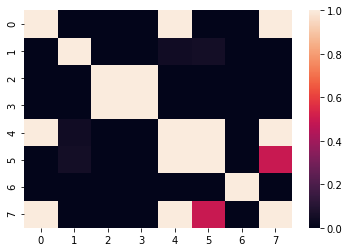

In [17]:
sns.heatmap(np.array(sp.posthoc_dunn([data[x] for x in data], p_adjust = 'bonferroni')))

In [23]:
data.keys()

dict_keys([('en', 'de'), ('en', 'es'), ('en', 'fr'), ('en', 'it'), ('en', 'pt'), ('es', 'en'), ('it', 'en'), ('pt', 'en')])

In [25]:
valid_keys = [('en', 'de'), ('en', 'es'), ('en', 'fr'), ('en', 'it')]

Text(0.5, 1.0, 'Statistical Significance')

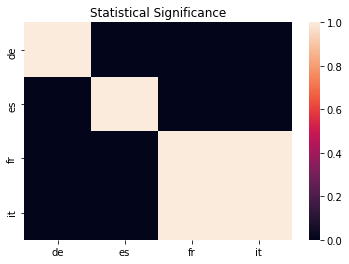

In [26]:
ax = sns.heatmap((np.array(sp.posthoc_dunn([data[x] for x in valid_keys], p_adjust = 'bonferroni')))[:4, :4])
ax.set_xticklabels([x[1] for x in data.keys()][:4])
ax.set_yticklabels([x[1] for x in data.keys()][:4]);

ax.set_title("Statistical Significance")

In [27]:
sp.posthoc_mannwhitney([data[x] for x in valid_keys], p_adjust = 'bonferroni')

,1,2,3,4
1,1.000000e+00,2.601330e-11,4.941872e-96,1.392399e-46
2,2.601330e-11,1.000000e+00,3.208903e-69,3.538934e-26
3,4.941872e-96,3.208903e-69,1.000000e+00,8.410504e-01
4,1.392399e-46,3.538934e-26,8.410504e-01,1.000000e+00


In [ ]:
sp.posthoc_mannwhitney([data[x] for x in data], p_adjust = 'bonferroni')

In [60]:
print(*list(enumerate(data.keys())), sep='\n')

(0, ('en', 'de'))
(1, ('en', 'es'))
(2, ('en', 'fr'))
(3, ('en', 'it'))
(4, ('en', 'pt'))
(5, ('es', 'en'))
(6, ('it', 'en'))
(7, ('pt', 'en'))


In [63]:
[(x, np.mean(data[x])) for x in data]

[(('en', 'de'), 0.8958368962794201),
 (('en', 'es'), 0.8915752719486799),
 (('en', 'fr'), 0.8787199475544316),
 (('en', 'it'), 0.8787010465800806),
 (('en', 'pt'), 0.89426637795892),
 (('es', 'en'), 0.8930269683189648),
 (('it', 'en'), 0.9071784372979556),
 (('pt', 'en'), 0.8944905696198209)]

Having en as ui_lang, 
    * There's difference between de and (es, fr, it). This coincides with language family
    * fr and it and not different. Same family, not the case for es and pt though. Can we say this btw from the statistical test?

Learning es from it and pt have differences too

Maybe it makes more sense to say that most pairs are different and highlight the difference to show that this is not the case for langauge families

# Q2: Difference between groups of users learning just single language and more than one langauges

In [31]:
user_grouped = list(df.groupby("user_id"))

In [32]:
learning_language_pairs = set()
for user in tqdm(user_grouped):
    learning_language_pairs.add(tuple(user[1].learning_language.unique().tolist()))

  0%|          | 0/115222 [00:00<?, ?it/s]

In [33]:
learning_language_pairs_stats = {x:0 for x in learning_language_pairs}
for user in tqdm(user_grouped):
    pair = tuple(user[1].learning_language.unique().tolist())
    learning_language_pairs_stats[pair] += 1

  0%|          | 0/115222 [00:00<?, ?it/s]

In [34]:
# Most combinations are very rare, only have one or two users
learning_language_pairs = set(filter(lambda x: learning_language_pairs_stats[x] >= 100, learning_language_pairs))

In [35]:
learning_language_pairs

{('de',),
 ('de', 'es'),
 ('de', 'fr'),
 ('en',),
 ('es',),
 ('es', 'de'),
 ('es', 'fr'),
 ('fr',),
 ('fr', 'de'),
 ('fr', 'es'),
 ('it',),
 ('pt',)}

In [36]:
user_grouped = list(df.groupby("user_id"))

In [37]:
data = {x:[] for x in learning_language_pairs}


for user in tqdm(user_grouped):
    lexeme_grouped = user[1].groupby("lexeme_id")
    pair = tuple(user[1].learning_language.unique().tolist())
    
    if pair not in learning_language_pairs:
        continue

    user_performance = []
    for lexeme in lexeme_grouped:
        last_entry = lexeme[1].iloc[-1]
        user_performance.append(last_entry.history_correct/last_entry.history_seen)
    user_performance_aggregate = np.mean(user_performance)
    data[pair].append(user_performance_aggregate)

  0%|          | 0/115222 [00:00<?, ?it/s]

In [38]:
stats.kruskal(*[data[x] for x in data])

KruskalResult(statistic=906.9016887870002, pvalue=2.0354078063411943e-187)

In [39]:
sp.posthoc_dunn([data[x] for x in data], p_adjust = 'bonferroni')

,1,2,3,4,5,6,7,8,9,10,11,12
1,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.075510e-04,1.000000e+00,3.635116e-04,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
2,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,7.857245e-04,1.000000e+00,1.957684e-03,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
3,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,7.714524e-23,6.280477e-02,9.581402e-17,1.000000,2.316166e-01,1.000000e+00,1.061447e-01
4,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,9.347315e-142,3.131169e-02,9.563483e-52,1.000000,2.158633e-15,1.000000e+00,6.600599e-02
5,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,7.005129e-03,1.000000e+00,1.534415e-02,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
6,0.000108,0.000786,7.714524e-23,9.347315e-142,0.007005,1.000000e+00,2.336632e-12,1.000000e+00,0.000945,4.977186e-64,1.696036e-86,4.523739e-10
7,1.000000,1.000000,6.280477e-02,3.131169e-02,1.000000,2.336632e-12,1.000000e+00,2.449360e-11,1.000000,2.177998e-04,4.577068e-02,1.000000e+00
8,0.000364,0.001958,9.581402e-17,9.563483e-52,0.015344,1.000000e+00,2.449360e-11,1.000000e+00,0.002123,2.570872e-24,5.270888e-42,2.472841e-09
9,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,9.453145e-04,1.000000e+00,2.122683e-03,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
10,1.000000,1.000000,2.316166e-01,2.158633e-15,1.000000,4.977186e-64,2.177998e-04,2.570872e-24,1.000000,1.000000e+00,9.874399e-09,1.121008e-03


<AxesSubplot:>

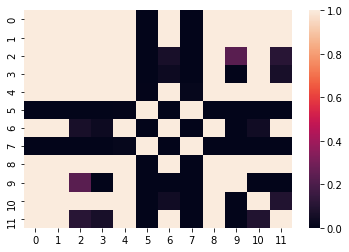

In [40]:
sns.heatmap(np.array(sp.posthoc_dunn([data[x] for x in data], p_adjust = 'bonferroni')))

<AxesSubplot:>

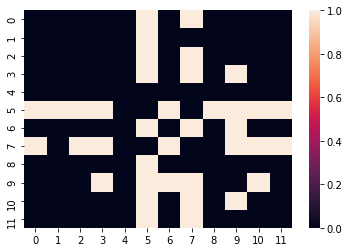

In [44]:
sns.heatmap(np.array(sp.posthoc_dunn([data[x] for x in data], p_adjust = 'bonferroni')) <= 0.001)

In [42]:
print(*list(enumerate(data.keys())), sep='\n')

(0, ('fr', 'es'))
(1, ('fr', 'de'))
(2, ('pt',))
(3, ('en',))
(4, ('de', 'fr'))
(5, ('fr',))
(6, ('es', 'fr'))
(7, ('it',))
(8, ('de', 'es'))
(9, ('es',))
(10, ('de',))
(11, ('es', 'de'))


In [132]:
[(x, np.mean(data[x])) for x in data]

[(('de', 'fr'), 0.8997225462754734),
 (('it', 'fr'), 0.8968245664377715),
 (('es', 'de'), 0.9079839894661338),
 (('es',), 0.8904327902748564),
 (('de', 'es'), 0.9014029802599554),
 (('it', 'es'), 0.9088100667851009),
 (('en',), 0.8942523173451581),
 (('fr', 'de'), 0.902390465580517),
 (('es', 'it'), 0.9085522782443044),
 (('de',), 0.8944121976086133),
 (('fr', 'it'), 0.8939549867637838),
 (('it',), 0.8768499231210403),
 (('it', 'de'), 0.9086512987415414),
 (('es', 'fr'), 0.9074863430867993),
 (('de', 'it'), 0.912860834418727),
 (('pt',), 0.8930656658451296),
 (('fr',), 0.8772713658302405),
 (('fr', 'es'), 0.9010795739178434)]